- **Classifiers**: Logistic Regression, SVM, Naive Bayes

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("✓ All basic imports successful!")

# Now try our custom modules
from dataset_loader import IndonesianSentimentLoader, DatasetFactory
from pipeline import TextClassificationPipeline, PipelineComparison, create_preset_pipelines
from vectorizers import VectorizerFactory, TFIDFVectorizer
from classifiers import ClassifierFactory

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✓ All custom modules imported successfully!")
print("\n=== System Ready! ===")

✓ All basic imports successful!
✓ All custom modules imported successfully!

=== System Ready! ===


## 2. Load Indonesian Sentiment Dataset

In [2]:
# Load the dataset
loader = DatasetFactory.create_loader("indonlu")  # Use "indonlu" for real dataset
dataset_splits = loader.load_data()

# Print dataset information
loader.print_dataset_info()

Loading indonlu dataset (smsa)...
Loading SMSA dataset from GitHub TSV files...

Dataset: indonlu (smsa)
----------------------------------------
Train set: 9852 samples
Validation set: 1129 samples
Test set: 412 samples

Label mapping: {0: 'negative', 1: 'positive'}

Label distribution in training set:
  negative: 3436 samples
  positive: 6416 samples

Sample texts:
  [positive] warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih ...
  [positive] lokasi strategis di jalan sumatera bandung . tempat nya nyaman terutama sofa di lantai 2 . paella ny...
  [positive] betapa bahagia nya diri ini saat unboxing paket dan barang nya bagus ! menetapkan beli lagi !...


In [3]:
# Get train/validation/test splits
X_train, X_val, X_test, y_train, y_val, y_test = loader.get_train_test_split(
    test_size=0.2, val_size=0.1, random_state=42, max_samples=1000
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Show some examples
print("\nSample training examples:")
for i in range(min(3, len(X_train))):
    label_name = loader.label_mapping.get(y_train[i], y_train[i])
    print(f"[{label_name}] {X_train[i]}")

Training set: 800 samples
Validation set: 100 samples
Test set: 100 samples

Sample training examples:
[positive] saya lebih menyukai menu lain di bandingkan bakso nya , menu favorit saya adalah cah kangkung nya . enak dan segar dengan kangkung yang 3 / 4 matang .
[positive] ikhlas dalam mengambil hikmah belajar dari kehidupan menjadikan kita orang yang kuat dalam menghadapi apa pun .
[positive] tempat nya enak banget apalagi kalau bawa pasangan . makanan di bistro kafe nya enak sampai bela - belain menginap disini buat makan buntut goreng nya


## 3. Quick Start: Single Pipeline Example

In [4]:
# Create a simple TF-IDF + Logistic Regression pipeline
# pipeline = TextClassificationPipeline(
#     vectorizer_type="tfidf",
#     classifier_type="logistic_regression",
#     vectorizer_params={
#         'max_features': 5000,
#         'ngram_range': (1, 2),
#         'use_preprocessing': True
#     },
#     classifier_params={
#         'C': 1.0,
#         'max_iter': 1000
#     }
# )


# pipeline = TextClassificationPipeline(
#     vectorizer_type="indobert",
#     classifier_type="logistic_regression",
#     vectorizer_params={
#         'model_name': 'indolem/indobert-base-uncased',
#         'pooling_strategy': 'mean',
#         'max_length': 256  # Shorter for faster processing
#     }
# )

pipeline = TextClassificationPipeline(
    vectorizer_type="indobert_finetune",
    classifier_type="dummy",  # Not used for fine-tuning
    vectorizer_params={
        'model_name': 'indolem/indobert-base-uncased',
        'max_length': 128,
        'num_labels': 2,
        'learning_rate': 2e-5,
        'num_epochs': 2,  # Small for demo
        'batch_size': 8,  # Small batch for memory efficiency
        'warmup_steps': 50
    }
)

print("Pipeline configuration:")
print(pipeline.get_pipeline_info())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pipeline configuration:
{'vectorizer_type': 'indobert_finetune', 'classifier_type': 'dummy', 'vectorizer_params': {'model_name': 'indolem/indobert-base-uncased', 'max_length': 128, 'num_labels': 2, 'learning_rate': 2e-05, 'num_epochs': 2, 'batch_size': 8, 'warmup_steps': 50}, 'classifier_params': {}, 'is_fitted': False, 'classes': None, 'training_time': None}


In [5]:
# Train the pipeline
pipeline.fit(X_train, y_train)

Training new model: indobert_finetune + dummy
Training data: 800 samples
Fine-tuning IndoBERT end-to-end (no separate classifier needed)...
Fine-tuning IndoBERT on 800 samples...
Device: cpu
Epochs: 2, Batch size: 8, LR: 2e-05


Epoch 1/2: 100%|██████████| 100/100 [11:44<00:00,  7.05s/it, loss=0.4354]


Epoch 1 completed. Average loss: 0.5101


Epoch 2/2: 100%|██████████| 100/100 [11:37<00:00,  6.97s/it, loss=0.0855]


Epoch 2 completed. Average loss: 0.2499
✅ Fine-tuning completed!
      ✓ IndoBERT fine-tuned in 1402.31s
✅ Pipeline training completed!
   Total time: 1402.32s
   Vectorizer: 1402.31s (100.0%)
   Classifier: 0.00s (0.0%)


TypeError: object of type 'NoneType' has no len()

In [6]:
# Evaluate on test set
results = pipeline.evaluate(X_test, y_test)

print("\n=== Evaluation Results ===")
print(f"Accuracy: {results['accuracy']:.4f}%")
print(f"F1-Score (Weighted): {results['f1_weighted']:.4f}%")
print(f"F1-Score (Macro): {results['f1_macro']:.4f}%")
print(f"Training Time: {results['training_time']:.2f} seconds")
print(f"Prediction Time: {results['prediction_time']:.4f} seconds")

Generating predictions: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


=== Evaluation Results ===
Accuracy: 92.0000%
F1-Score (Weighted): 91.8809%
F1-Score (Macro): 91.7321%
Training Time: 1402.32 seconds
Prediction Time: 12.1607 seconds


In [7]:
# Show detailed classification report
print("\n=== Classification Report ===")
print(pipeline.get_classification_report(X_test, y_test))


=== Classification Report ===


Generating predictions: 100%|██████████| 13/13 [00:06<00:00,  2.14it/s]

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        55
           1       1.00      0.82      0.90        45

    accuracy                           0.92       100
   macro avg       0.94      0.91      0.92       100
weighted avg       0.93      0.92      0.92       100



Generating predictions: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


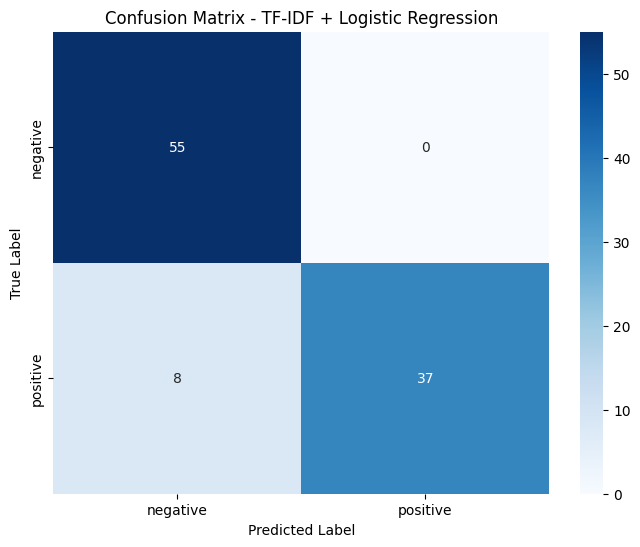

In [8]:
# Plot confusion matrix
cm = pipeline.get_confusion_matrix(X_test, y_test)
labels = [loader.label_mapping[i] for i in sorted(loader.label_mapping.keys())]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - TF-IDF + Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 4. Testing Individual Predictions

In [9]:
# Test with custom Indonesian texts
test_texts = [
    "Makanan ini sangat enak dan pelayanannya memuaskan!",
    "Pelayanan buruk sekali, sangat mengecewakan",
    "Cuaca hari ini biasa saja, tidak terlalu panas",
    "Film yang menakjubkan, sangat saya rekomendasikan!",
    "Produk ini tidak sesuai dengan ekspektasi saya"
]

predictions = pipeline.predict(test_texts)
probabilities = pipeline.predict_proba(test_texts)

print("=== Individual Predictions ===")
for i, text in enumerate(test_texts):
    pred_label = loader.label_mapping[predictions[i]]
    confidence = np.max(probabilities[i])
    print(f"\nText: {text}")
    print(f"Predicted: {pred_label} (confidence: {confidence:.3f})")
    
    # Show all probabilities
    print("All probabilities:")
    for j, prob in enumerate(probabilities[i]):
        label_name = loader.label_mapping[j]
        print(f"  {label_name}: {prob:.3f}")

Generating predictions: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]

=== Individual Predictions ===

Text: Makanan ini sangat enak dan pelayanannya memuaskan!
Predicted: positive (confidence: 0.963)
All probabilities:
  negative: 0.037
  positive: 0.963

Text: Pelayanan buruk sekali, sangat mengecewakan
Predicted: negative (confidence: 0.855)
All probabilities:
  negative: 0.855
  positive: 0.145

Text: Cuaca hari ini biasa saja, tidak terlalu panas
Predicted: positive (confidence: 0.757)
All probabilities:
  negative: 0.243
  positive: 0.757

Text: Film yang menakjubkan, sangat saya rekomendasikan!
Predicted: positive (confidence: 0.865)
All probabilities:
  negative: 0.135
  positive: 0.865

Text: Produk ini tidak sesuai dengan ekspektasi saya
Predicted: negative (confidence: 0.922)
All probabilities:
  negative: 0.922
  positive: 0.078


## 5. Experimenting with Different Vectorizers

### 5.1 TF-IDF with Different Parameters

In [ ]:
# # Test different TF-IDF configurations
# tfidf_configs = [
#     {'name': 'TF-IDF (unigrams)', 'params': {'max_features': 5000, 'ngram_range': (1, 1)}},
#     {'name': 'TF-IDF (bigrams)', 'params': {'max_features': 5000, 'ngram_range': (1, 2)}},
#     {'name': 'TF-IDF (trigrams)', 'params': {'max_features': 5000, 'ngram_range': (1, 3)}},
#     {'name': 'TF-IDF (large vocab)', 'params': {'max_features': 10000, 'ngram_range': (1, 2)}},
# ]

# tfidf_results = []

# for config in tfidf_configs:
#     print(f"\nTesting {config['name']}...")
    
#     pipeline_test = TextClassificationPipeline(
#         vectorizer_type="tfidf",
#         classifier_type="logistic_regression",
#         vectorizer_params=config['params']
#     )
    
#     pipeline_test.fit(X_train, y_train)
#     results = pipeline_test.evaluate(X_test, y_test)
    
#     tfidf_results.append({
#         'name': config['name'],
#         'accuracy': results['accuracy'],
#         'f1_weighted': results['f1_weighted'],
#         'training_time': results['training_time']
#     })
    
#     print(f"Accuracy: {results['accuracy']:.4f}, F1: {results['f1_weighted']:.4f}")

# # Display results
# tfidf_df = pd.DataFrame(tfidf_results)
# print("\n=== TF-IDF Configuration Comparison ===")
# print(tfidf_df.round(4))

### 5.2 IndoBERT (if available)

In [ ]:
# # Test IndoBERT vectorizer (this might take longer)
# # Note: IndoBERT requires GPU for reasonable performance

# try:
#     print("Testing IndoBERT vectorizer...")
#     print("Warning: This may take several minutes without GPU acceleration")
    
#     indobert_pipeline = TextClassificationPipeline(
#         vectorizer_type="indobert",
#         classifier_type="logistic_regression",
#         vectorizer_params={
#             'model_name': 'indolem/indobert-base-uncased',
#             'pooling_strategy': 'mean',
#             'max_length': 256  # Shorter for faster processing
#         }
#     )
    
#     # Use smaller subset for faster training
#     subset_size = min(50, len(X_train))  # Use only first 50 samples
#     X_train_subset = X_train[:subset_size]
#     y_train_subset = y_train[:subset_size]
    
#     indobert_pipeline.fit(X_train_subset, y_train_subset)
#     indobert_results = indobert_pipeline.evaluate(X_test, y_test)
    
#     print(f"\nIndoBERT Results:")
#     print(f"Accuracy: {indobert_results['accuracy']:.4f}")
#     print(f"F1-Score: {indobert_results['f1_weighted']:.4f}")
#     print(f"Training Time: {indobert_results['training_time']:.2f} seconds")
    
# except Exception as e:
#     print(f"IndoBERT test failed: {str(e)}")
#     print("This is expected if you don't have the required dependencies installed")
#     print("You can install them with: pip install transformers torch")

## 6. Experimenting with Different Classifiers

In [ ]:
# # Test different classifiers with TF-IDF
# classifier_configs = [
#     {'name': 'Logistic Regression', 'type': 'logistic_regression', 'params': {'C': 1.0}},
#     {'name': 'SVM (Linear)', 'type': 'svm', 'params': {'C': 1.0, 'kernel': 'linear'}},
#     {'name': 'Random Forest', 'type': 'random_forest', 'params': {'n_estimators': 100}},
#     {'name': 'Naive Bayes', 'type': 'naive_bayes', 'params': {'alpha': 1.0}}
# ]

# classifier_results = []

# # Use consistent TF-IDF parameters
# tfidf_params = {'max_features': 5000, 'ngram_range': (1, 2), 'use_preprocessing': True}

# for config in classifier_configs:
#     print(f"\nTesting {config['name']}...")
    
#     try:
#         pipeline_test = TextClassificationPipeline(
#             vectorizer_type="tfidf",
#             classifier_type=config['type'],
#             vectorizer_params=tfidf_params,
#             classifier_params=config['params']
#         )
        
#         pipeline_test.fit(X_train, y_train)
#         results = pipeline_test.evaluate(X_test, y_test)
        
#         classifier_results.append({
#             'classifier': config['name'],
#             'accuracy': results['accuracy'],
#             'f1_weighted': results['f1_weighted'],
#             'f1_macro': results['f1_macro'],
#             'training_time': results['training_time']
#         })
        
#         print(f"Accuracy: {results['accuracy']:.4f}, F1: {results['f1_weighted']:.4f}")
        
#     except Exception as e:
#         print(f"Error with {config['name']}: {str(e)}")

# # Display results
# classifier_df = pd.DataFrame(classifier_results)
# print("\n=== Classifier Comparison ===")
# print(classifier_df.round(4))

In [ ]:
# # Visualize classifier comparison
# if len(classifier_results) > 0:
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
#     # Accuracy comparison
#     ax1.bar(classifier_df['classifier'], classifier_df['accuracy'])
#     ax1.set_title('Accuracy by Classifier')
#     ax1.set_ylabel('Accuracy')
#     ax1.tick_params(axis='x', rotation=45)
    
#     # F1-Score comparison
#     ax2.bar(classifier_df['classifier'], classifier_df['f1_weighted'])
#     ax2.set_title('F1-Score (Weighted) by Classifier')
#     ax2.set_ylabel('F1-Score')
#     ax2.tick_params(axis='x', rotation=45)
    
#     plt.tight_layout()
#     plt.show()

## 7. Comprehensive Pipeline Comparison

In [ ]:
# # Use the PipelineComparison class for systematic comparison
# comparison = PipelineComparison()

# # Add different pipeline configurations
# pipelines_to_compare = [
#     {
#         'name': 'TF-IDF + LR',
#         'vectorizer': 'tfidf',
#         'classifier': 'logistic_regression',
#         'v_params': {'max_features': 5000, 'ngram_range': (1, 2)},
#         'c_params': {'C': 1.0}
#     },
#     {
#         'name': 'TF-IDF + SVM',
#         'vectorizer': 'tfidf',
#         'classifier': 'svm',
#         'v_params': {'max_features': 5000, 'ngram_range': (1, 2)},
#         'c_params': {'C': 1.0, 'kernel': 'linear'}
#     },
#     {
#         'name': 'TF-IDF + RF',
#         'vectorizer': 'tfidf',
#         'classifier': 'random_forest',
#         'v_params': {'max_features': 5000, 'ngram_range': (1, 2)},
#         'c_params': {'n_estimators': 50}  # Reduced for faster training
#     }
# ]

# for config in pipelines_to_compare:
#     pipeline = TextClassificationPipeline(
#         vectorizer_type=config['vectorizer'],
#         classifier_type=config['classifier'],
#         vectorizer_params=config['v_params'],
#         classifier_params=config['c_params']
#     )
#     comparison.add_pipeline(pipeline, config['name'])

# # Run comparison
# comparison_results = comparison.compare_pipelines(X_train, y_train, X_test, y_test)
# print("\n=== Pipeline Comparison Results ===")
# print(comparison_results)

In [ ]:
# # Find the best pipeline
# best_pipeline_info = comparison.get_best_pipeline(metric='f1_weighted')
# print(f"\nBest pipeline (by F1-weighted): {best_pipeline_info['pipeline_name']}")
# print(f"F1-Score: {best_pipeline_info['f1_weighted']:.4f}")
# print(f"Accuracy: {best_pipeline_info['accuracy']:.4f}")

In [ ]:
# # Visualize comparison results
# if len(comparison_results) > 0:
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
#     # Accuracy
#     ax1.bar(comparison_results['pipeline_name'], comparison_results['accuracy'])
#     ax1.set_title('Accuracy Comparison')
#     ax1.set_ylabel('Accuracy')
#     ax1.tick_params(axis='x', rotation=45)
    
#     # F1-Score
#     ax2.bar(comparison_results['pipeline_name'], comparison_results['f1_weighted'])
#     ax2.set_title('F1-Score (Weighted) Comparison')
#     ax2.set_ylabel('F1-Score')
#     ax2.tick_params(axis='x', rotation=45)
    
#     # Training Time
#     ax3.bar(comparison_results['pipeline_name'], comparison_results['training_time'])
#     ax3.set_title('Training Time Comparison')
#     ax3.set_ylabel('Time (seconds)')
#     ax3.tick_params(axis='x', rotation=45)
    
#     # Prediction Time
#     ax4.bar(comparison_results['pipeline_name'], comparison_results['prediction_time'])
#     ax4.set_title('Prediction Time Comparison')
#     ax4.set_ylabel('Time (seconds)')
#     ax4.tick_params(axis='x', rotation=45)
    
#     plt.tight_layout()
#     plt.show()

## 8. Interactive Pipeline Builder

In [ ]:
# # Interactive function to build and test custom pipelines
# def build_custom_pipeline():
#     """
#     Interactive function to build a custom pipeline
#     """
#     print("=== Custom Pipeline Builder ===")
#     print("Available vectorizers:", VectorizerFactory.get_available_vectorizers())
#     print("Available classifiers:", list(ClassifierFactory.get_available_classifiers().keys()))
#     print("\nNote: Modify the code below to test different configurations")
    
#     # Example custom configuration - modify these as needed
#     custom_config = {
#         'vectorizer_type': 'tfidf',  # Change to 'indobert' if available
#         'classifier_type': 'logistic_regression',  # Try 'svm', 'random_forest', 'naive_bayes'
#         'vectorizer_params': {
#             'max_features': 8000,  # Try different values: 5000, 10000, 15000
#             'ngram_range': (1, 3),  # Try (1,1), (1,2), (1,3), (2,3)
#             'use_preprocessing': True
#         },
#         'classifier_params': {
#             'C': 0.1,  # Try different C values: 0.1, 1.0, 10.0
#             'max_iter': 1000
#         }
#     }
    
#     # Build and test the custom pipeline
#     custom_pipeline = TextClassificationPipeline(**custom_config)
    
#     print(f"\nBuilding custom pipeline: {custom_config['vectorizer_type']} + {custom_config['classifier_type']}")
#     custom_pipeline.fit(X_train, y_train)
    
#     custom_results = custom_pipeline.evaluate(X_test, y_test)
#     print(f"\nCustom Pipeline Results:")
#     print(f"Accuracy: {custom_results['accuracy']:.4f}")
#     print(f"F1-Score (Weighted): {custom_results['f1_weighted']:.4f}")
#     print(f"F1-Score (Macro): {custom_results['f1_macro']:.4f}")
#     print(f"Training Time: {custom_results['training_time']:.2f} seconds")
    
#     return custom_pipeline, custom_results

# # Run the custom pipeline builder
# custom_pipeline, custom_results = build_custom_pipeline()

## 9. Feature Analysis (for TF-IDF)

In [ ]:
# # Analyze TF-IDF features and their importance
# if hasattr(custom_pipeline.vectorizer, 'get_feature_names') and hasattr(custom_pipeline.classifier, 'get_feature_importance'):
#     try:
#         # Get feature names and importance
#         feature_names = custom_pipeline.vectorizer.get_feature_names()
#         feature_importance = custom_pipeline.classifier.get_feature_importance()
        
#         # Create DataFrame for analysis
#         if len(feature_importance.shape) > 1:
#             # Multi-class case - use absolute mean across classes
#             importance_scores = np.abs(feature_importance).mean(axis=0)
#         else:
#             # Binary case
#             importance_scores = np.abs(feature_importance)
        
#         feature_df = pd.DataFrame({
#             'feature': feature_names,
#             'importance': importance_scores
#         }).sort_values('importance', ascending=False)
        
#         print("\n=== Top 20 Most Important Features ===")
#         print(feature_df.head(20))
        
#         # Plot top features
#         plt.figure(figsize=(12, 8))
#         top_features = feature_df.head(15)
#         plt.barh(range(len(top_features)), top_features['importance'])
#         plt.yticks(range(len(top_features)), top_features['feature'])
#         plt.xlabel('Importance Score')
#         plt.title('Top 15 Most Important Features (TF-IDF + Logistic Regression)')
#         plt.gca().invert_yaxis()
#         plt.tight_layout()
#         plt.show()
        
#     except Exception as e:
#         print(f"Feature analysis failed: {str(e)}")
# else:
#     print("Feature analysis not available for this pipeline configuration")

## 10. Save and Load Pipeline

In [ ]:
# # Save the best performing pipeline
# model_path = "best_sentiment_pipeline.pkl"

# try:
#     custom_pipeline.save_pipeline(model_path)
#     print(f"Pipeline saved to {model_path}")
    
#     # Test loading
#     loaded_pipeline = TextClassificationPipeline.load_pipeline(model_path)
#     print("Pipeline loaded successfully!")
    
#     # Test that loaded pipeline works
#     test_text = ["Makanan ini sangat enak!"]
#     prediction = loaded_pipeline.predict(test_text)
#     label_name = loader.label_mapping[prediction[0]]
#     print(f"\nTest prediction with loaded model: '{test_text[0]}' -> {label_name}")
    
# except Exception as e:
#     print(f"Error saving/loading pipeline: {str(e)}")

## 11. Summary and Next Steps

In [ ]:
# print("=== Modular Text Classification System Summary ===")
# print()
# print("✅ Components Successfully Demonstrated:")
# print("   • TF-IDF Vectorizer with Indonesian preprocessing")
# print("   • Multiple classifier options (LR, SVM, RF, NB)")
# print("   • Modular pipeline with easy component switching")
# print("   • Comprehensive evaluation and comparison tools")
# print("   • Feature importance analysis")
# print("   • Model persistence (save/load)")
# print()
# print("🎯 Key Benefits:")
# print("   • Easy to switch between vectorizers and classifiers")
# print("   • Consistent API across different components")
# print("   • Built-in evaluation and comparison tools")
# print("   • Indonesian text preprocessing included")
# print("   • Extensible architecture for new components")
# print()
# print("🚀 Suggested Next Steps:")
# print("   1. Try with real IndoNLU dataset (change 'sample' to 'indonlu')")
# print("   2. Experiment with IndoBERT if you have GPU resources")
# print("   3. Add more sophisticated preprocessing techniques")
# print("   4. Implement cross-validation for more robust evaluation")
# print("   5. Add ensemble methods combining multiple models")
# print("   6. Implement active learning for improving model with less data")
# print()
# print("📝 Usage Examples:")
# print("   # Quick single pipeline")
# print("   pipeline = TextClassificationPipeline('tfidf', 'logistic_regression')")
# print("   pipeline.fit(X_train, y_train)")
# print("   predictions = pipeline.predict(X_test)")
# print()
# print("   # Compare multiple pipelines")
# print("   comparison = PipelineComparison()")
# print("   comparison.add_pipeline(pipeline1, 'Config 1')")
# print("   results = comparison.compare_pipelines(X_train, y_train, X_test, y_test)")

## 12. Playground Cell - Try Your Own Experiments!

In [ ]:
# This cell is for your own experiments!
# Try different configurations, test new ideas, or analyze results in more detail

print("=== Available Vectorizers ===")
print("Available vectorizers:", VectorizerFactory.get_available_vectorizers())

# Example 1: Traditional TF-IDF + SVM Pipeline
print("\n=== Example 1: TF-IDF + SVM ===")
tfidf_pipeline = TextClassificationPipeline(
    vectorizer_type="tfidf",
    classifier_type="svm",
    vectorizer_params={
        'max_features': 5000,
        'ngram_range': (1, 2),
        'use_preprocessing': True
    },
    classifier_params={
        'C': 0.5,
        'kernel': 'linear'
    }
)

print("TF-IDF Pipeline configuration:")
print(tfidf_pipeline.get_pipeline_info())

# Example 2: IndoBERT Frozen Features + Logistic Regression  
print("\n=== Example 2: IndoBERT Frozen Features ===")
indobert_frozen_pipeline = TextClassificationPipeline(
    vectorizer_type="indobert",
    classifier_type="logistic_regression",
    vectorizer_params={
        'model_name': 'indolem/indobert-base-uncased',
        'max_length': 128,
        'pooling_strategy': 'mean'
    },
    classifier_params={
        'C': 1.0,
        'max_iter': 1000
    }
)

print("IndoBERT Frozen Features Pipeline configuration:")
print(indobert_frozen_pipeline.get_pipeline_info())

# Example 3: IndoBERT Fine-tuning (End-to-End)
print("\n=== Example 3: IndoBERT Fine-tuning ===")
indobert_finetune_pipeline = TextClassificationPipeline(
    vectorizer_type="indobert_finetune",
    classifier_type="dummy",  # Not used for fine-tuning
    vectorizer_params={
        'model_name': 'indolem/indobert-base-uncased',
        'max_length': 128,
        'num_labels': 2,
        'learning_rate': 2e-5,
        'num_epochs': 2,  # Small for demo
        'batch_size': 8,  # Small batch for memory efficiency
        'warmup_steps': 50
    }
)

print("IndoBERT Fine-tuning Pipeline configuration:")
print(indobert_finetune_pipeline.get_pipeline_info())

# Compare approaches with small subset for demo
print("\n=== Quick Comparison with Small Dataset ===")
# Use very small dataset for quick demo (adjust as needed)
X_train_demo, X_val_demo, X_test_demo, y_train_demo, y_val_demo, y_test_demo = loader.get_train_test_split(
    test_size=0.2, val_size=0.1, random_state=42, max_samples=100  # Very small for demo
)

print(f"Demo dataset: {len(X_train_demo)} train, {len(X_test_demo)} test samples")

# 1. Quick TF-IDF baseline
print("\n--- Training TF-IDF Baseline ---")
tfidf_pipeline.fit(X_train_demo, y_train_demo, verbose=True)
tfidf_results = tfidf_pipeline.evaluate(X_test_demo, y_test_demo)

print(f"TF-IDF Results: {tfidf_results['accuracy']:.1f}% accuracy, {tfidf_results['f1_weighted']:.1f}% F1")

# 2. IndoBERT Fine-tuning (uncomment to try - requires GPU for reasonable speed)
print("\n--- IndoBERT Fine-tuning (requires patience!) ---")
print("WARNING: This will take several minutes even with small dataset!")
print("Uncomment the lines below to try fine-tuning:")

# try:
#     indobert_finetune_pipeline.fit(X_train_demo, y_train_demo, verbose=True)
#     finetune_results = indobert_finetune_pipeline.evaluate(X_test_demo, y_test_demo)
#     print(f"Fine-tuned Results: {finetune_results['accuracy']:.1f}% accuracy, {finetune_results['f1_weighted']:.1f}% F1")
# except Exception as e:
#     print(f"Fine-tuning failed: {e}")

# Test predictions with different approaches
print("\n=== Testing Individual Predictions ===")
test_texts = [
    "Makanan di restoran ini sangat enak dan pelayanannya memuaskan!",
    "Pelayanan buruk sekali, sangat mengecewakan"
]

print("TF-IDF Predictions:")
for text in test_texts:
    pred = tfidf_pipeline.predict([text])[0]
    prob = tfidf_pipeline.predict_proba([text])[0]
    label = loader.label_mapping[pred]
    confidence = max(prob)
    print(f"  '{text}' -> {label} ({confidence:.3f})")

print("\nTo try IndoBERT fine-tuning:")
print("1. Uncomment the fine-tuning code above")  
print("2. Increase max_samples for better results (but longer training)")
print("3. Ensure you have sufficient GPU memory or use smaller batch_size")
print("4. Monitor GPU usage during training")

# Additional hyperparameter suggestions
print("\n=== Fine-tuning Hyperparameter Suggestions ===")
print("For experimentation, try these parameter combinations:")
print("- Small dataset (<1000): epochs=3-5, batch_size=8-16, lr=2e-5")
print("- Medium dataset (1000-5000): epochs=2-3, batch_size=16-32, lr=1e-5") 
print("- Large dataset (>5000): epochs=1-2, batch_size=32-64, lr=5e-6")
print("- For CPU training: batch_size=4-8, expect 10x slower training")